In [45]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import squarify
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [46]:
df = pd.read_csv('netflix_titles.csv')

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [47]:
df['date_added'] = pd.to_datetime(df['date_added'])

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      6173 non-null   object        
 4   cast          7982 non-null   object        
 5   country       7976 non-null   object        
 6   date_added    8797 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8803 non-null   object        
 9   duration      8804 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 825.8+ KB


In [49]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

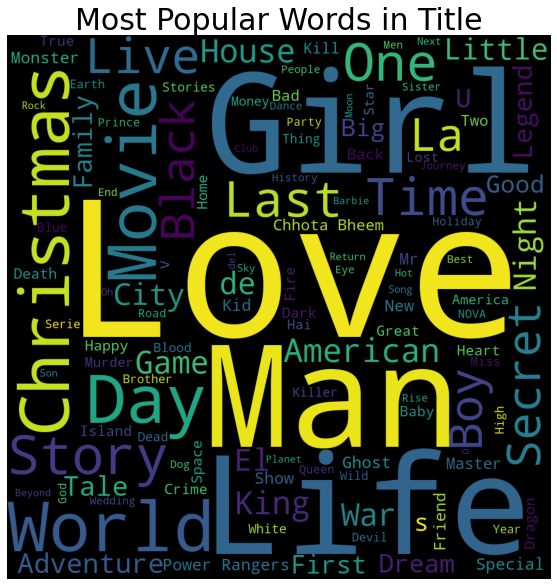

In [50]:
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color = 'black', width = 1000,  height = 1000, max_words = 121).generate(' '.join(df['title']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Words in Title',fontsize = 30)
plt.show()

# EDA

## Content Type 

In [51]:
df['type'].unique()

array(['Movie', 'TV Show'], dtype=object)

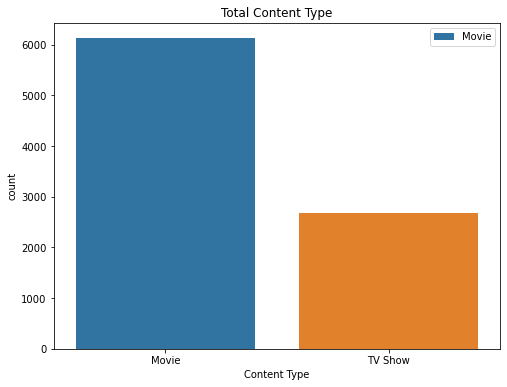

In [52]:
f, ax = plt.subplots(nrows=1, figsize = (8,6))

sns.countplot(x=df['type'], ax=ax)
plt.title('Total Content Type')
plt.xlabel('Content Type')
plt.legend(df['type'].unique())

Netflix content contains more movies than tv shows

## release_year

In [53]:
content_release = pd.DataFrame(df.groupby(['release_year','type']).show_id.count())

content_release

show_id
release_year type            
1925         TV Show        1
1942         Movie          2
1943         Movie          3
1944         Movie          3
1945         Movie          3
...                       ...
2019         TV Show      397
2020         Movie        517
             TV Show      436
2021         Movie        277
             TV Show      315

[119 rows x 1 columns]

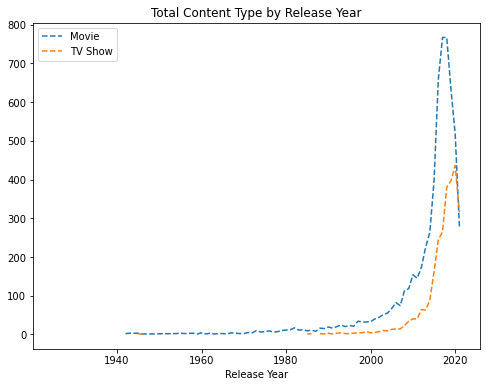

In [54]:
content_release.unstack().plot(kind = 'line', figsize = (8, 6), title = 'Total Content Type by Release Year', linestyle = 'dashed')
plt.xlabel('Release Year')
plt.legend(['Movie', 'TV Show'], loc = 2)

In [55]:
release = df['release_year'].value_counts().reset_index()
release.rename({'index': 'release_year', 'release_year':'count'}, axis=1, inplace=True)

In [56]:
release

,release_year,count
0,2018,1147
1,2017,1032
2,2019,1030
3,2020,953
4,2016,902
...,...,...
69,1966,1
70,1925,1
71,1947,1
72,1959,1


Text(0.5, 0, 'Release Year')

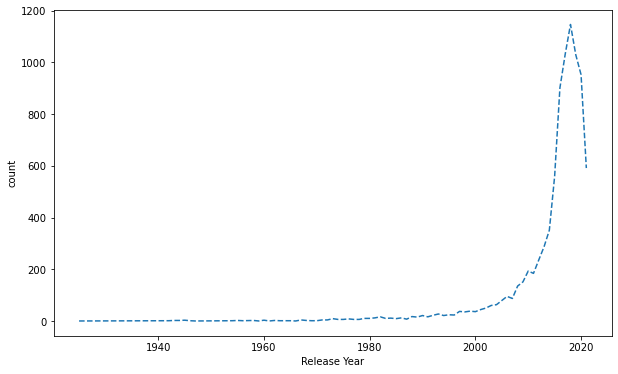

In [57]:
f, ax = plt.subplots(nrows=1, figsize = (10,6))

sns.lineplot(data = release, x ='release_year', y='count', linestyle='dashed')
plt.xlabel('Release Year')

The highest release number of content happened in 2018 - 2019

## Rating 

In [58]:
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

Text(0.5, 0, 'Rating')

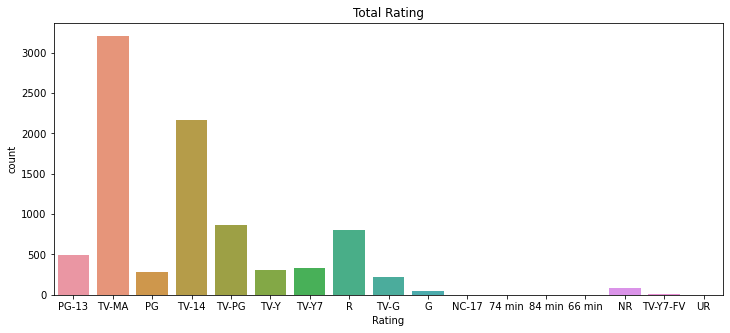

In [59]:
f, ax = plt.subplots(nrows=1, figsize = (12,5))

sns.countplot(x=df['rating'], ax=ax)
plt.title('Total Rating')
plt.xlabel('Rating')

Most of the programs on Netflix is TV-MA, TV-14, TV-PG, and R

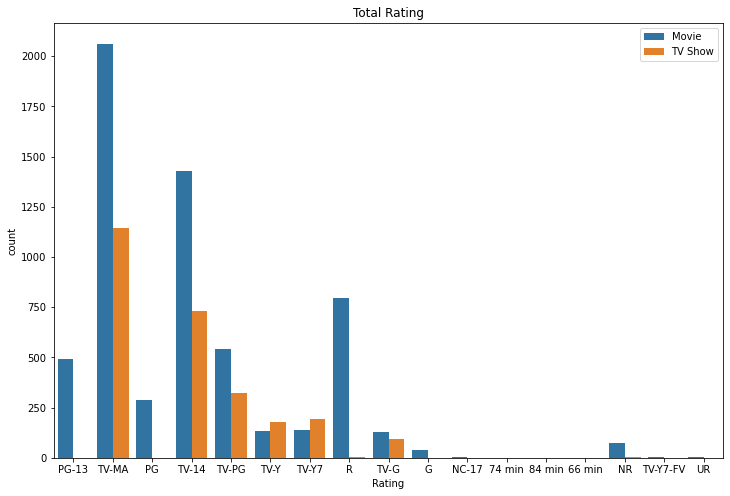

In [60]:
f, ax = plt.subplots(nrows=1, figsize = (12,8))

sns.countplot(x=df['rating'], hue=df['type'], ax=ax)
plt.title('Total Rating')
plt.xlabel('Rating')
plt.legend(loc=1)

- Lots of movie rating is PG-13 and R opposite to tv show rating which almost/ don't contain those ratings.
- Most of TV shows rating is TV-MA and TV-14. 

## Genres 

In [61]:
df['Genres'] = df['listed_in'].str.extract('([A-Z]\w{2,})', expand=True)

df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,Genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,Documentaries
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,International
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,Crime
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,Docuseries
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,9.0,International
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",2019.0,11.0,Cult
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",2019.0,7.0,Kids
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,2019.0,11.0,Comedies
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",2020.0,1.0,Children


In [62]:
genre = df['Genres'].value_counts().reset_index()
genre.rename({'index':'Genres', 'Genres':'count'}, inplace=True, axis=1)

genre

,Genres,count
0,Dramas,1667
1,Comedies,1330
2,International,902
3,Action,899
4,Documentaries,829
5,Children,605
6,Crime,399
7,Kids,388
8,Stand,368
9,Horror,286


In [63]:
fig = px.treemap(genre, path=['Genres', 'count'], color='Genres', hover_data=['Genres', 'count'])

fig.show()

## Country

In [64]:
top_country = df['country'].value_counts().reset_index()[:10]
top_country.rename({'index':'country', 'country':'count'}, axis=1, inplace = True)

In [65]:
top_country

,country,count
0,United States,2818
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199
5,Canada,181
6,Spain,145
7,France,124
8,Mexico,110
9,Egypt,106


Text(0.5, 0, 'Country')

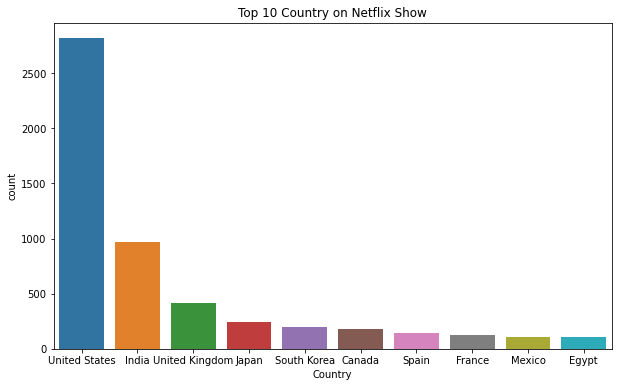

In [66]:
f, ax = plt.subplots(nrows=1, figsize = (10,6))

sns.barplot(data = top_country, x = 'country', y='count')
plt.title('Top 10 Country on Netflix Show')
plt.xlabel('Country')

## director 

In [67]:
US_netflix = df[df['country'] == 'United States']

US_netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,Genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,Documentaries
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,2021.0,9.0,Comedies
15,s16,TV Show,Dear White People,NaN,"Logan Browning, Brandon P. Bell, DeRon Horton,...",United States,2021-09-22,2021,TV-MA,4 Seasons,"TV Comedies, TV Dramas",Students of color navigate the daily slights a...,2021.0,9.0,Comedies
27,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,2021-09-20,2010,PG-13,103 min,Comedies,Mourning the loss of their beloved junior high...,2021.0,9.0,Comedies
28,s29,Movie,Dark Skies,Scott Stewart,"Keri Russell, Josh Hamilton, J.K. Simmons, Dak...",United States,2021-09-19,2013,PG-13,97 min,"Horror Movies, Sci-Fi & Fantasy",A family’s idyllic suburban life shatters when...,2021.0,9.0,Horror


In [68]:
India_netflix = df[df['country'] == 'India']

India_netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,Genres
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,9.0,International
24,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,2021-09-21,1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...,2021.0,9.0,Comedies
39,s40,TV Show,Chhota Bheem,NaN,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jig...",India,2021-09-16,2021,TV-Y7,3 Seasons,Kids' TV,"A brave, energetic little boy with superhuman ...",2021.0,9.0,Kids
50,s51,TV Show,Dharmakshetra,NaN,"Kashmira Irani, Chandan Anand, Dinesh Mehta, A...",India,2021-09-15,2014,TV-PG,1 Season,"International TV Shows, TV Dramas, TV Sci-Fi &...","After the ancient Great War, the god Chitragup...",2021.0,9.0,International
66,s67,TV Show,Raja Rasoi Aur Anya Kahaniyan,NaN,NaN,India,2021-09-15,2014,TV-G,1 Season,"Docuseries, International TV Shows",Explore the history and flavors of regional In...,2021.0,9.0,Docuseries


In [69]:
top_US_director = US_netflix['director'].value_counts().reset_index()[:10]
top_US_director.rename({'index':'director', 'director':'count'}, axis=1, inplace = True)

Text(0.5, 0, 'Director')

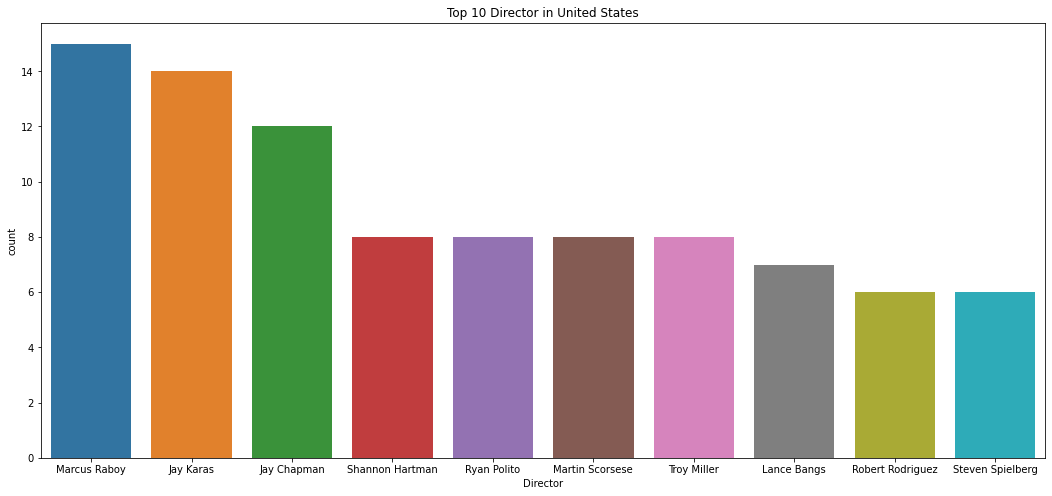

In [70]:
f, ax = plt.subplots(nrows=1, figsize = (18,8))

sns.barplot(data = top_US_director, x = 'director', y='count', ax=ax)
plt.title('Top 10 Director in United States')
plt.xlabel('Director')

In [71]:
top_india_director = India_netflix['director'].value_counts().reset_index()[:10]
top_india_director.rename({'index':'director', 'director':'count'}, axis=1, inplace = True)

Text(0.5, 0, 'Director')

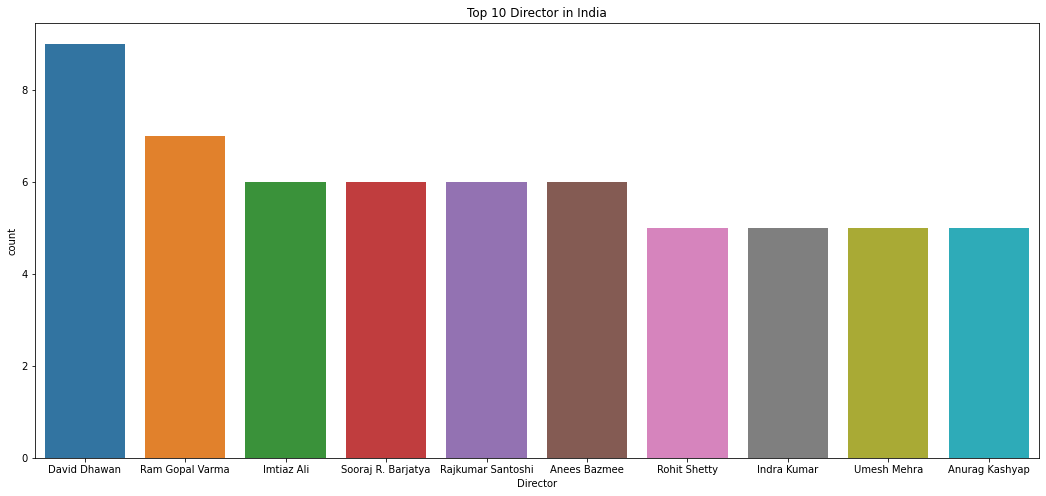

In [72]:
f, ax = plt.subplots(nrows=1, figsize = (18,8))

sns.barplot(data = top_india_director, x = 'director', y='count', ax=ax)
plt.title('Top 10 Director in India')
plt.xlabel('Director')

## cast 

In [73]:
top_US_actor = ",".join(US_netflix['cast'].fillna("")).split(",")
Counter(top_US_actor).most_common(11)

[('', 330),
 ('Adam Sandler', 20),
 (' Fred Tatasciore', 15),
 (' Molly Shannon', 14),
 (' Samuel L. Jackson', 13),
 (' Erin Fitzgerald', 13),
 (' David Koechner', 12),
 (' Sean Astin', 12),
 (' Seth Rogen', 11),
 (' Peter Facinelli', 11),
 (' Ray Liotta', 11)]

In [74]:
top_US_actor = [('Adam Sandler', 20),
 ('Samuel L. Jackson', 19),
 ('Fred Tatasciore', 17),
 ('Molly Shannon', 15),
 ('Seth Rogen', 15),
 ('Chris Rock', 14),
 ('Erin Fitzgerald', 14),
 ('Morgan Freeman', 14),
 ('Nicolas Cage', 14),
 ('Laura Bailey', 14)]

top_US_actor = pd.DataFrame(top_US_actor)
top_US_actor.rename({0:'actors', 1:'count'}, axis=1, inplace=True)

Text(0.5, 0, 'Actor')

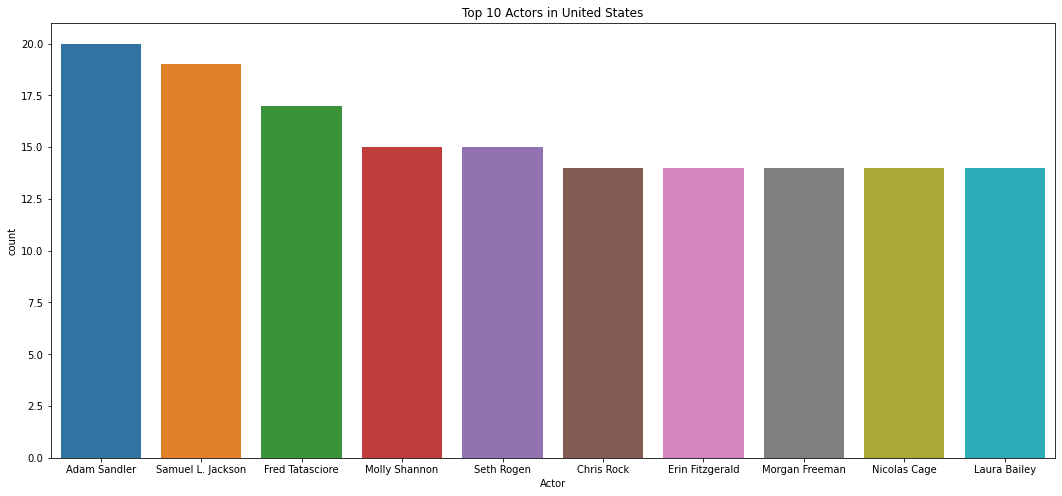

In [75]:
f, ax = plt.subplots(nrows=1, figsize = (18,8))

sns.barplot(data = top_US_actor, x = 'actors', y='count', ax=ax)
plt.title('Top 10 Actors in United States')
plt.xlabel('Actor')

In [76]:
top_india_actor = ",".join(India_netflix['cast'].fillna("")).split(",")
Counter(top_india_actor).most_common(11)

[(' Anupam Kher', 36),
 ('', 32),
 ('Shah Rukh Khan', 24),
 (' Paresh Rawal', 24),
 (' Om Puri', 23),
 ('Akshay Kumar', 22),
 (' Boman Irani', 21),
 ('Amitabh Bachchan', 20),
 (' Naseeruddin Shah', 19),
 (' Kareena Kapoor', 19),
 (' Asrani', 17)]

In [77]:
top_india_actor = [(' Anupam Kher', 36),
 ('Shah Rukh Khan', 24),
 (' Paresh Rawal', 24),
 (' Om Puri', 23),
 ('Akshay Kumar', 22),
 (' Boman Irani', 21),
 ('Amitabh Bachchan', 20),
 (' Naseeruddin Shah', 19),
 (' Kareena Kapoor', 19),
 (' Asrani', 17)]

top_india_actor = pd.DataFrame(top_india_actor)
top_india_actor.rename({0:'actors', 1:'count'}, axis=1, inplace=True)

Text(0.5, 0, 'Actor')

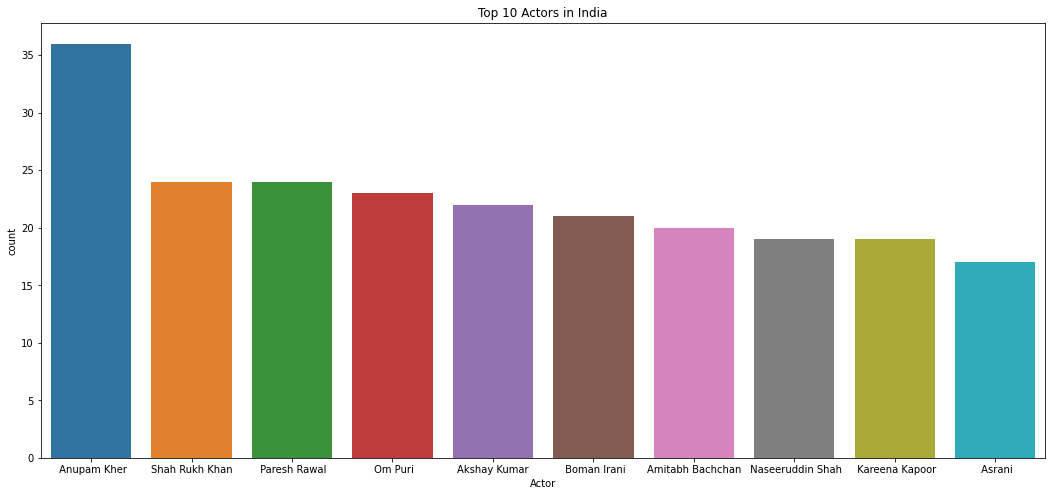

In [78]:
f, ax = plt.subplots(nrows=1, figsize = (18,8))

sns.barplot(data = top_india_actor, x = 'actors', y='count', ax=ax)
plt.title('Top 10 Actors in India')
plt.xlabel('Actor')

# Recommendation System

In [90]:
new_df = df.fillna('')

new_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,Genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,2021-09-25 00:00:00,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,Documentaries
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24 00:00:00,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,International
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",,2021-09-24 00:00:00,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,Crime
3,s4,TV Show,Jailbirds New Orleans,,,,2021-09-24 00:00:00,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,9.0,Docuseries
4,s5,TV Show,Kota Factory,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24 00:00:00,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,9.0,International


In [91]:
def clean_data(x):
    return str.lower(x.replace(" ", ""))

In [92]:
features = ['title','director','cast','listed_in','description']

new_df = new_df[features]

In [93]:
for feature in features:
    new_df[feature] = new_df[feature].apply(clean_data)
    
new_df.head()

,title,director,cast,listed_in,description
0,dickjohnsonisdead,kirstenjohnson,,documentaries,"asherfathernearstheendofhislife,filmmakerkirst..."
1,blood&water,,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou..."
2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille..."
3,jailbirdsneworleans,,,"docuseries,realitytv","feuds,flirtationsandtoilettalkgodownamongthein..."
4,kotafactory,,"mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...","internationaltvshows,romantictvshows,tvcomedies",inacityofcoachingcentersknowntotrainindia’sfin...


In [94]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

In [95]:
new_df['soup'] = new_df.apply(create_soup, axis=1)

In [96]:
new_df.head()

,title,director,cast,listed_in,description,soup
0,dickjohnsonisdead,kirstenjohnson,,documentaries,"asherfathernearstheendofhislife,filmmakerkirst...",dickjohnsonisdead kirstenjohnson documentarie...
1,blood&water,,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou...","blood&water amaqamata,khosingema,gailmabalane..."
2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille...","ganglands julienleclercq samibouajila,tracygot..."
3,jailbirdsneworleans,,,"docuseries,realitytv","feuds,flirtationsandtoilettalkgodownamongthein...","jailbirdsneworleans docuseries,realitytv feu..."
4,kotafactory,,"mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...","internationaltvshows,romantictvshows,tvcomedies",inacityofcoachingcentersknowntotrainindia’sfin...,"kotafactory mayurmore,jitendrakumar,ranjanraj..."


In [97]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(new_df['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [98]:
new_df = new_df.reset_index()
indices = pd.Series(new_df.index, index=new_df['title'])

new_df.head()

,index,title,director,cast,listed_in,description,soup
0,0,dickjohnsonisdead,kirstenjohnson,,documentaries,"asherfathernearstheendofhislife,filmmakerkirst...",dickjohnsonisdead kirstenjohnson documentarie...
1,1,blood&water,,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou...","blood&water amaqamata,khosingema,gailmabalane..."
2,2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille...","ganglands julienleclercq samibouajila,tracygot..."
3,3,jailbirdsneworleans,,,"docuseries,realitytv","feuds,flirtationsandtoilettalkgodownamongthein...","jailbirdsneworleans docuseries,realitytv feu..."
4,4,kotafactory,,"mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...","internationaltvshows,romantictvshows,tvcomedies",inacityofcoachingcentersknowntotrainindia’sfin...,"kotafactory mayurmore,jitendrakumar,ranjanraj..."


In [103]:
def get_recommendations(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    return new_df['title'].iloc[movie_indices]

In [104]:
get_recommendations('Her Private Life', cosine_sim)

2349    it'sokaytonotbeokay
1778     kongsuniandfriends
2037          recordofyouth
289         thecrownedclown
3610               let’seat
4132    romanceisabonusbook
3358        bringiton,ghost
1483       alovesobeautiful
1875      dodosolsollalasol
3071              reply1988
Name: title, dtype: object

# References

- https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243
- https://www.kaggle.com/code/niharika41298/netflix-visualizations-recommendation-eda